In [2]:
import numpy as np
import pandas as pd
import keras
from keras import optimizers
import re
from warnings import warn
from unet import construct_unet
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# !curl -O https://raw.githubusercontent.com/DSLituiev/cardioloader/master/unet.py

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:

fn_meta = '/data/kidney/tables/splits-2019-03-24.csv'
meta = pd.read_csv(fn_meta, index_col=0)['set']
name = ''
roi_unique_labels = []
########################################
# fix here
########################################
slide_ids = {}
for kk in ['train', 'val', 'test']:
    slide_ids[kk] = meta[meta==kk].index.tolist()


In [5]:
!ls /data/kidney/data/lymphoid_agg/newdata/data_1024/la_split/train/lymph | head

07272cf63c51cf065e5d7117d2a085491a9dfe9c-x2343-y23969-t1+29-r105-tissue+lymph_agg.json
07272cf63c51cf065e5d7117d2a085491a9dfe9c-x2343-y23969-t1+29-r105-tissue+lymph_agg.png
07272cf63c51cf065e5d7117d2a085491a9dfe9c-x2343-y24993-t1+29-r114-tissue+lymph_agg.json
07272cf63c51cf065e5d7117d2a085491a9dfe9c-x2343-y24993-t1+29-r114-tissue+lymph_agg.png
07272cf63c51cf065e5d7117d2a085491a9dfe9c-x2343-y26017-t1+19+29-r121-tissue+glom+lymph_agg.json
07272cf63c51cf065e5d7117d2a085491a9dfe9c-x2343-y26017-t1+19+29-r121-tissue+glom+lymph_agg.png
09eb9369342c45a23a3b52408eaabfe55ded9c7a-x16654-y11395-t2+36-r55-tissue+lymph_agg.json
09eb9369342c45a23a3b52408eaabfe55ded9c7a-x16654-y11395-t2+36-r55-tissue+lymph_agg.png
09eb9369342c45a23a3b52408eaabfe55ded9c7a-x36001-y11392-t34+9-r14-tissue+lymph_agg.json
09eb9369342c45a23a3b52408eaabfe55ded9c7a-x36001-y11392-t34+9-r14-tissue+lymph_agg.png
ls: write error: Broken pipe


In [6]:
from generators import PngDir, JsonDir, SegmSet, np_collate
from torch.utils.data import Dataset, DataLoader

In [7]:
fn_dcm = '07272cf63c51cf065e5d7117d2a085491a9dfe9c-x2343-y23969-t1+29-r105-tissue+lymph_agg.png'
# fn_dcm = '07272cf63c51cf065e5d7117d2a085491a9dfe9c-x2343-y23969-.png'
matches = re.match('([\da-f]+)-x([\d]+)-y([\d]+)-.*\.png', fn_dcm)
matches.groups()

('07272cf63c51cf065e5d7117d2a085491a9dfe9c', '2343', '23969')

In [66]:
batch_size = 8
num_workers = 4

dfs = {}
segmsets = {}
dloaders = {}
for set_ in ['train', 'val', 'test']:
    dfs[set_] = {}
    for label in ['norm', 'lymph']:
        dirname = f'/data/kidney/data/lymphoid_agg/newdata/data_1024/la_split/{set_}/{label}'
        pngdir = PngDir(dirname, verbose=False)
        jsondir = JsonDir(dirname, verbose=False)
        dfs[set_][label] = pd.concat([pngdir.content, jsondir.content], axis=1)
        dfs[set_][label].index.names = ['slide_id', 'x', 'y']
        
    segmsets[set_] = SegmSet(dfs[set_]['lymph'], shape=(256,256))
    dloaders[set_] = DataLoader(segmsets[set_], collate_fn=np_collate,
                                num_workers=num_workers,
                                batch_size=batch_size,
                                shuffle=(set_=='train'))

/home/exx/.conda/envs/digipath/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [10]:
# import json
# from pycocotools.mask import decode

# def tissue_name_positive(x):
#     return ('lymph' in x) or ('infl' in x)

# fnjson = dloaders['val'].dataset.filenames.iloc[0]['json']
# with open(fnjson) as fh:
#     rois = json.load(fh)

# any([decode(rr) for rr in rois if tissue_name_positive(rr['name'])])
# segmsets[set_][0]

In [28]:
import imgaug.augmenters as iaa
import imgaug as ia
# iaa.seed(2)

seq = iaa.Sequential([
#     iaa.CoarseDropout(0.1, size_percent=0.2),
    iaa.ElasticTransformation(alpha=10, sigma=1),
    iaa.Affine(
            scale=1.2,
            translate_percent=(5),
            translate_px=None,
            rotate=(-30, 30),
            shear=(5.0),
            cval = 250,
        ),
     iaa.Sometimes(0.3, iaa.AddToHueAndSaturation((-15, 15))),
     iaa.Sometimes(0.3, iaa.GaussianBlur(sigma=(0.0, 3.0))),
])

In [21]:
dfs['train']['lymph'].iloc[0]

png     /data/kidney/data/lymphoid_agg/newdata/data_10...
json    /data/kidney/data/lymphoid_agg/newdata/data_10...
Name: (07272cf63c51cf065e5d7117d2a085491a9dfe9c, 2343, 23969), dtype: object

In [13]:
# sample = SegmSet.parse_sample(dfs['train']['lymph'].iloc[0], 
#                               positive=False,
#                              )

In [23]:
def data_gen(x, augment=False):
    while True:
        for sample in x:
            #sample['image'], sample['mask'][...,np.newaxis]
            if augment:
                bg = seq(images=sample['image'],#.astype(np.float16), 
                         segmentation_maps=sample['mask'],
                        return_batch=True,
                    )
                yield bg.images_aug, bg.segmentation_maps_aug[..., np.newaxis].astype(np.float32)
            else:
                yield (keras.applications.vgg16.preprocess_input(sample['image']),
                        sample['mask'][..., np.newaxis].astype(np.float32))

In [26]:
for img, msk in data_gen(dloaders['val']):
    break
# batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


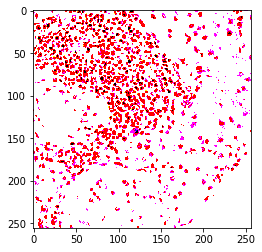

In [27]:
plt.imshow(img[4])
# plt.imshow(msk[2,...,0])

In [17]:
# plt.imshow(dloaders['val'].dataset[4]['image'])

In [18]:
img.shape

(8, 256, 256, 3)

In [5]:
width, height = 256, 256
unet = construct_unet(width, height, encoder = 'vgg16', freeze_encoder=True)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [35]:
unet.compile(optimizer=optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
unet.fit_generator(data_gen(dloaders['train']), steps_per_epoch=len(dloaders['train']),
                   validation_data=data_gen(dloaders['val']), validation_steps=len(dloaders['val']),
                   epochs=20,
                  )

Epoch 1/20
23/23 [==============================] - 11s 483ms/step - loss: 0.2168 - acc: 0.9261 - val_loss: 0.2399 - val_acc: 0.9149
Epoch 2/20
23/23 [==============================] - 8s 335ms/step - loss: 0.2269 - acc: 0.9217 - val_loss: 0.2421 - val_acc: 0.9151
Epoch 3/20
23/23 [==============================] - 8s 349ms/step - loss: 0.2269 - acc: 0.9224 - val_loss: 0.2499 - val_acc: 0.9153
Epoch 4/20
23/23 [==============================] - 8s 348ms/step - loss: 0.2290 - acc: 0.9208 - val_loss: 0.2426 - val_acc: 0.9155
Epoch 5/20
23/23 [==============================] - 8s 351ms/step - loss: 0.2116 - acc: 0.9283 - val_loss: 0.2463 - val_acc: 0.9159
Epoch 6/20
23/23 [==============================] - 8s 343ms/step - loss: 0.2196 - acc: 0.9247 - val_loss: 0.2439 - val_acc: 0.9163
Epoch 7/20
23/23 [==============================] - 8s 351ms/step - loss: 0.2126 - acc: 0.9277 - val_loss: 0.2710 - val_acc: 0.9104
Epoch 8/20
23/23 [==============================] - 8s 349ms/step - loss: 0

In [111]:
# unet.save('checkpoints/unet_dlituiev_2019-05-17.h5')

In [37]:
val_predicted = unet.predict_generator(data_gen(dloaders['val']), steps=len(dloaders['val']),)

In [41]:
test_predicted = unet.predict_generator(data_gen(dloaders['test']), steps=len(dloaders['test']),)

In [102]:
dloaders['test'].dataset.filenames.loc['f7f931a5cf3185a385e9aa34e6e9a566fc88000c', :].index.get_level_values('x')#.index
# dloaders['test'].dataset.filenames

Int64Index([ 1809,  2833,  2833, 10001, 10001, 11025, 11025, 12049, 12049,
            12049, 14346, 15370, 16145, 16394, 17169, 17169, 17169, 17418,
            17418, 18193, 18193, 18442, 18442, 18442, 19466, 19466, 20490,
            21265, 21265, 21514, 21514, 22289, 22289, 22538, 23313, 23313,
            23562, 24337, 25361, 25361, 25361, 26385, 26385, 27658, 27658,
            28682, 28682, 33553, 34577, 36874, 40721, 40721, 41745, 41745,
            41745, 42769, 42769, 42769, 44042, 44042, 45066, 45066, 45066,
            45066, 45841, 46865, 46865, 46865, 47889, 49937, 49937, 50961,
            50961, 51985, 54033, 54033, 54033, 55057, 55057, 55057, 55057,
            56081, 56081, 56081, 56081, 57105, 57105, 57105, 58129],
           dtype='int64', name='x')

In [90]:
index_test = dloaders['test'].dataset.filenames.index.to_frame().reset_index(drop=True)
# index_test = [x.tolist() for _, x in index_test.iterrows()]
('c886827fe8c10b4699a0f1616331e36b46a05617', 44677, 6426)
len(index_test)

155

In [80]:
index_test.slide_id.unique()

array(['70bb3032750d09e7549928c0dbf79afc30d7cb68',
       'a1fc67fbb21f43b9e8904b9b46bd94f83493b37a',
       'c886827fe8c10b4699a0f1616331e36b46a05617',
       'dfe3ee768f72bddd289c7d5bb88b15cbb89be7e6',
       'f7f931a5cf3185a385e9aa34e6e9a566fc88000c'], dtype=object)

In [107]:
np.where((index_test.slide_id == 'c886827fe8c10b4699a0f1616331e36b46a05617') &\
            (index_test.x == 44677) & \
            (index_test.y == 6426)
        )

np.where((index_test.slide_id == 'f7f931a5cf3185a385e9aa34e6e9a566fc88000c') &\
            (index_test.x == 41745) #& \
#             (index_test.y == 20967)
        )

(array([118, 119, 120]),)

In [75]:
# [tuple(x) for x in index_test.values]
# index_test